In [1]:
import os
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

from src.utils.utils import safe_parse_feat

### Load the Data

In [2]:
# Define the path to the processed data
processed_path = "../data/processed/"
recommendations_path = "../data/recommendations/"

# Load the recommendations
als_recommendations = pd.read_csv(os.path.join(recommendations_path, "als_recommendations.csv"))
content_based_recommendations = pd.read_csv(os.path.join(recommendations_path, "content_based_recommendations.csv"))
hybrid_recommendations = pd.read_csv(os.path.join(recommendations_path, "hybrid_recommendations.csv"))
nn_recommendations = pd.read_csv(os.path.join(recommendations_path, "nn_recommendations.csv"))
combined_recommendations = pd.read_csv(os.path.join(recommendations_path, "combined_recommendations.csv"))

# Load ground truth data
interactions_test = pd.read_csv(os.path.join(processed_path, "interactions_test.csv"))
user_features = pd.read_csv(os.path.join(processed_path, "user_features.csv"))
video_metadata = pd.read_csv(os.path.join(processed_path, "video_metadata.csv"))

# Convert recommendations DataFrames to dictionaries
def load_recommendations(df):
    recommendations = {}
    for _, row in df.iterrows():
        user_id = row['user_id']
        recs = row.drop('user_id').dropna().astype(int).tolist()
        recommendations[user_id] = recs
    return recommendations

als_recommendations = load_recommendations(als_recommendations)
content_based_recommendations = load_recommendations(content_based_recommendations)
hybrid_recommendations = load_recommendations(hybrid_recommendations)
nn_recommendations = load_recommendations(nn_recommendations)
combined_recommendations = load_recommendations(combined_recommendations)

video_metadata["feat"] = video_metadata["feat"].apply(safe_parse_feat)
video_metadata = video_metadata[video_metadata["feat"].notnull()]

user_features["preferred_category"] = user_features["preferred_category"].apply(safe_parse_feat)
user_features = user_features[user_features["preferred_category"].notnull()]

user_features["friends_preferred_category"] = user_features["friends_preferred_category"].apply(safe_parse_feat)
user_features = user_features[user_features["friends_preferred_category"].notnull()]

### Build ground truth
(videos actually watched by each user)

In [3]:
ground_truth = defaultdict(set)
for _, row in interactions_test.iterrows():
    ground_truth[row['user_id']].add(row['video_id'])

# Create a dictionary to map video IDs to their categories
video_categories = video_metadata.set_index('video_id')['feat'].to_dict()

# Create a dictionary to map user IDs to their preferred categories and friends' preferred categories
user_preferred_category = user_features.set_index('user_id')['preferred_category'].to_dict()
user_friends_preferred_category = user_features.set_index('user_id')['friends_preferred_category'].to_dict()

### Evaluation function

In [4]:
def evaluate_recommendations(recommendations, ground_truth, video_categories, user_preferred_category, user_friends_preferred_category, k=10):
    precision_list = []
    category_precision_list = []
    hit_count = 0
    category_hit_count = 0
    user_count = 0

    for user_id, recs in recommendations.items():
        if user_id not in ground_truth:
            continue  # No test data for this user

        true_items = ground_truth[user_id]
        k_user = k
        recommended_items = recs[:k_user]
        hits = len(set(recommended_items) & true_items)

        # Get user's preferred categories and friends' preferred categories
        preferred_category = set(user_preferred_category.get(user_id, []))
        friends_preferred_category = set(user_friends_preferred_category.get(user_id, []))
        all_preferred_category = preferred_category.union(friends_preferred_category)

        # Check if recommended videos are in the user's or friends' preferred categories
        category_hits = 0
        for vid in recommended_items:
            video_category = set(video_categories.get(vid, []))
            if video_category.intersection(all_preferred_category):
                category_hits += 1

        precision = hits / k_user
        category_precision = category_hits / k_user
        hit = 1 if hits > 0 else 0
        category_hit = 1 if category_hits > 0 else 0

        precision_list.append(precision)
        category_precision_list.append(category_precision)
        hit_count += hit
        category_hit_count += category_hit
        user_count += 1

    precision_at_k = np.mean(precision_list)
    category_precision_at_k = np.mean(category_precision_list)
    hit_rate = hit_count / user_count if user_count > 0 else 0
    category_hit_rate = category_hit_count / user_count if user_count > 0 else 0

    return {
        'Precision@K': precision_at_k,
        'CategoryPrecision@K': category_precision_at_k,
        'HitRate@K': hit_rate,
        'CategoryHitRate@K': category_hit_rate,
        'Evaluated Users': user_count
    }

### Evaluate recommendations

In [5]:
def print_res(method, results):
    print("\n--- ", method, " ---")
    for key, value in results.items():
        if isinstance(value, float):
            value = round(value, 3)
        else:
            value = int(value)
        print(f"{key}: {value}")


# Evaluate ALS recommendations
als_results = evaluate_recommendations(als_recommendations, ground_truth, video_categories, user_preferred_category, user_friends_preferred_category, k=30)
print_res("ALS Recommendations", als_results)

# Evaluate content-based recommendations
content_based_results = evaluate_recommendations(content_based_recommendations, ground_truth, video_categories, user_preferred_category, user_friends_preferred_category, k=30)
print_res("Content Based Recommendations", content_based_results)

# Evaluate hybrid recommendations
hybrid_results = evaluate_recommendations(hybrid_recommendations, ground_truth, video_categories, user_preferred_category, user_friends_preferred_category, k=30)
print_res("Hybrid Recommendations", hybrid_results)

# Evaluate NN recommendations
nn_results = evaluate_recommendations(nn_recommendations, ground_truth, video_categories, user_preferred_category, user_friends_preferred_category, k=30)
print_res("NN Recommendations", nn_results)

# Evaluate combined recommendations
combined_results = evaluate_recommendations(combined_recommendations, ground_truth, video_categories, user_preferred_category, user_friends_preferred_category, k=30)
print_res("Combined Recommendations", combined_results)


---  ALS Recommendations  ---
Precision@K: 0.029
CategoryPrecision@K: 0.014
HitRate@K: 0.87
CategoryHitRate@K: 0.422
Evaluated Users: 7176

---  Content Based Recommendations  ---
Precision@K: 0.02
CategoryPrecision@K: 0.302
HitRate@K: 0.434
CategoryHitRate@K: 0.907
Evaluated Users: 7176

---  Hybrid Recommendations  ---
Precision@K: 0.039
CategoryPrecision@K: 0.333
HitRate@K: 0.689
CategoryHitRate@K: 1.0
Evaluated Users: 7176

---  NN Recommendations  ---
Precision@K: 0.004
CategoryPrecision@K: 0.064
HitRate@K: 0.124
CategoryHitRate@K: 0.244
Evaluated Users: 500

---  Combined Recommendations  ---
Precision@K: 0.049
CategoryPrecision@K: 0.318
HitRate@K: 0.911
CategoryHitRate@K: 0.943
Evaluated Users: 7176


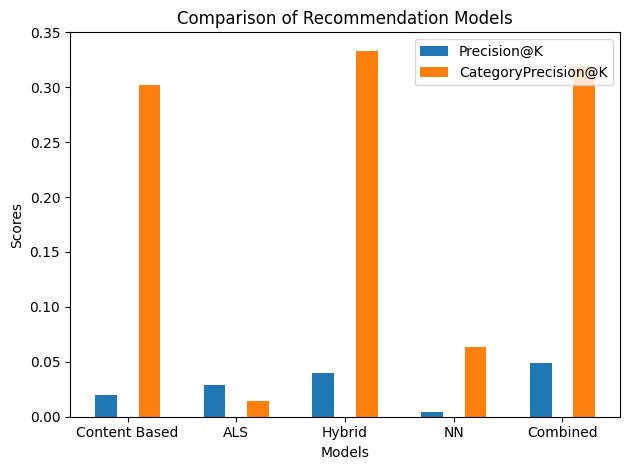

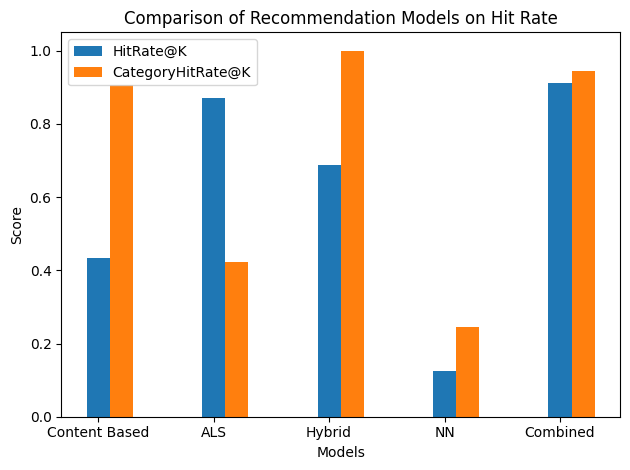

In [6]:
# Plot comparison of results
models = ['Content Based', 'ALS', 'Hybrid', 'NN', 'Combined']

precision_values = [content_based_results['Precision@K'], als_results['Precision@K'], hybrid_results['Precision@K'], nn_results['Precision@K'], combined_results['Precision@K']]

category_precision_values = [content_based_results['CategoryPrecision@K'], als_results['CategoryPrecision@K'], hybrid_results['CategoryPrecision@K'], nn_results['CategoryPrecision@K'], combined_results['CategoryPrecision@K']]

hit_rate_values = [content_based_results['HitRate@K'], als_results['HitRate@K'], hybrid_results['HitRate@K'], nn_results['HitRate@K'], combined_results['HitRate@K']]

category_hit_rate_values = [content_based_results['CategoryHitRate@K'], als_results['CategoryHitRate@K'], hybrid_results['CategoryHitRate@K'], nn_results['CategoryHitRate@K'], combined_results['CategoryHitRate@K']]

x = np.arange(len(models))
width = 0.2

fig1, ax1 = plt.subplots()
rects1 = ax1.bar(x - width, precision_values, width, label='Precision@K')
rects2 = ax1.bar(x + width, category_precision_values, width, label='CategoryPrecision@K')

ax1.set_xlabel('Models')
ax1.set_ylabel('Scores')
ax1.set_title('Comparison of Recommendation Models')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
ax1.legend()

fig1.tight_layout()
plt.show()

fig2, ax2 = plt.subplots()
rects3 = ax2.bar(x, hit_rate_values, width, label='HitRate@K')
rects4 = ax2.bar(x + width, category_hit_rate_values, width, label='CategoryHitRate@K')

ax2.set_xlabel('Models')
ax2.set_ylabel('Score')
ax2.set_title('Comparison of Recommendation Models on Hit Rate')
ax2.set_xticks(x)
ax2.set_xticklabels(models)
ax2.legend()

fig2.tight_layout()
plt.show()
